In [1]:
#| code-fold: true

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(42);

We have two datasets of disjoint discrete integer sequences $L$ and $R$. They represent sentences in different languages with no common words.

We do not know correct possible translations from one sequence to another, however we would like to let the user of a system propose their rules of translation.  We would like to learn an algorithm to rewrite sequences in one language into sequences in another from examples.

Let's define a generator of languages and translation examples to train our metalearner on:

In [6]:
def make_sequence(K=10, L=6, R=6, T=3):
    """Make a (K-1)-shot R-way T-step training sequences.
    Assumes a latent language defined as a mapping between fixed permutations of alphabets L and R
    and produces K usage examples of the language.
    """
    soh, stx = L+R, L+R+1

    vocabR = [[x] for x in (torch.randperm(R) + L)]
    vocabL = [[x] for x in (torch.randperm(L))]

    # assemble source sentences
    sources = torch.randint(0, len(vocabL), (K, T))
    source_sequences = [
        [token for word in source_sequence for token in vocabL[word]] 
        for source_sequence in sources
    ]

    # assemble target sentences by translating source
    target_sequences = [
        [token for word in source_sequence for token in vocabR[word]]
        for source_sequence in sources
    ]

    # format training sequences
    training_sequence = [tok for s,t  in zip(source_sequences, target_sequences)
                         for tok in [soh] + s + [stx] + t] + [soh]
    return torch.tensor(training_sequence)

Let's define our meta RNN:

In [ ]:
N, D, L, R = 32, 512, 6, 6
soh, stx, pad = L+R, L+R+1, L+R+2

class LM(nn.Module):
    def __init__(self):
        super().__init__()
        self.words = nn.Embedding(L+R+3, D, padding_idx=pad)
        self.rnn = nn.LSTM(D, 1024, num_layers=1, batch_first=True)
        self.classifier = nn.Linear(1024, L+R+3)

    def forward(self, inputs):
        x = self.words(inputs)
        x, _ = self.rnn(x)
        x = self.classifier(x)
        return x

Now, let's metatrain the model. The loss curve on the left shows three different phases of training.

The plot on the right show a per token loss plot of the all $K=10$ examples from the first training sequence in a batch.
First three tokens are equiprobable, as there is no useful distribution of tokens given in the data.

The ␂ token is expected and has a very high probability, and then the remaining three tokens have a probability of 1 when the model learns to perform the task.

Number of "hanging" curves suggest how many examples were necessary to learn the language.

<Figure size 600x200 with 0 Axes>

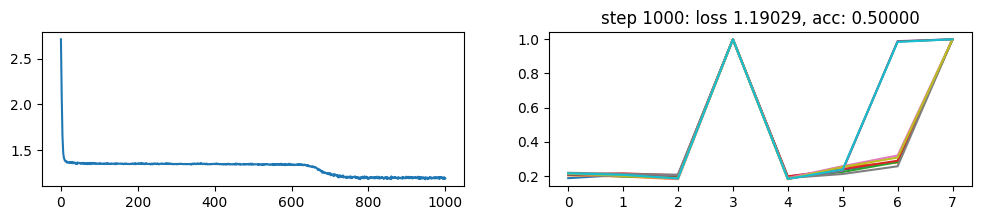

<Figure size 600x200 with 0 Axes>

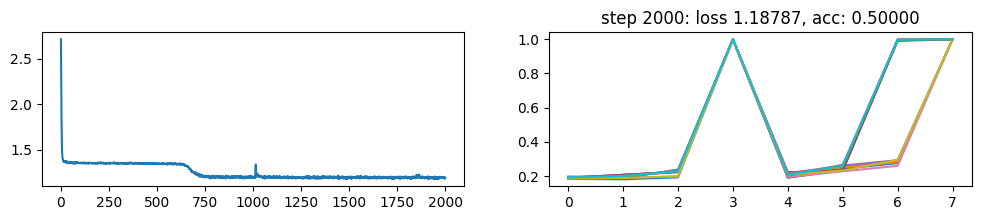

<Figure size 600x200 with 0 Axes>

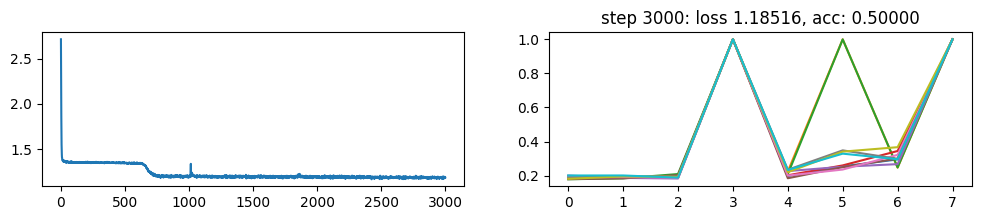

<Figure size 600x200 with 0 Axes>

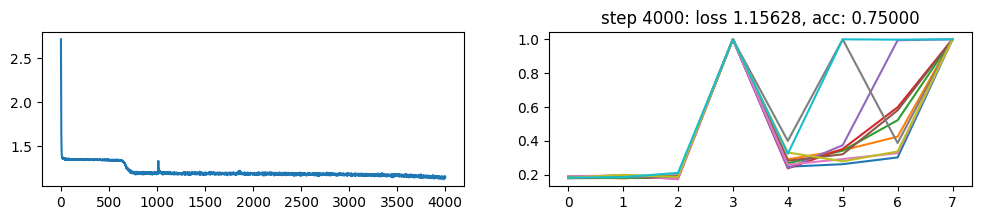

<Figure size 600x200 with 0 Axes>

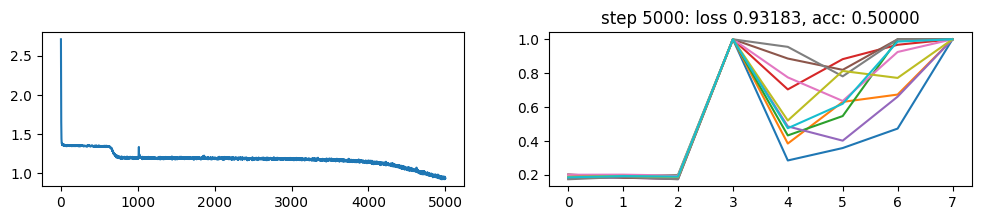

<Figure size 600x200 with 0 Axes>

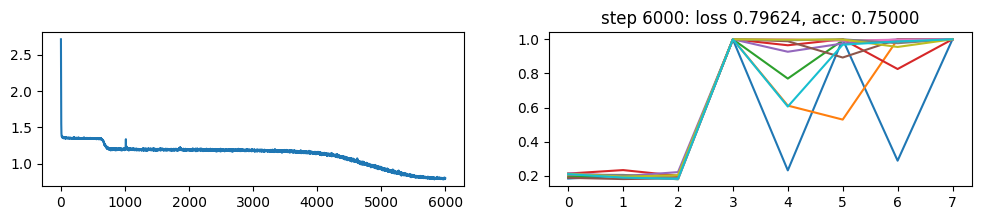

<Figure size 600x200 with 0 Axes>

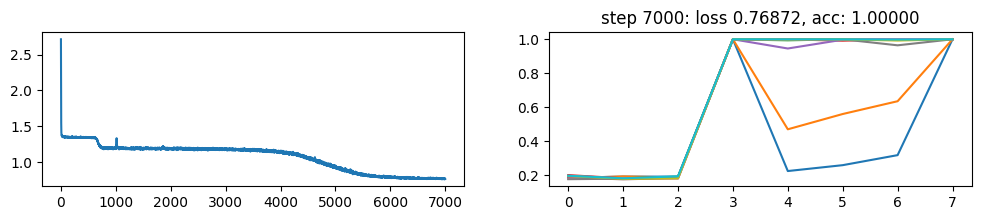

<Figure size 600x200 with 0 Axes>

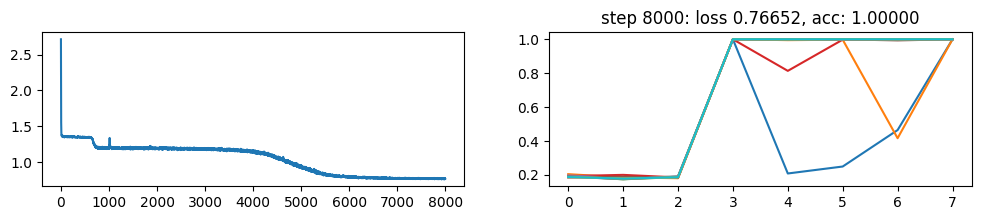

<Figure size 600x200 with 0 Axes>

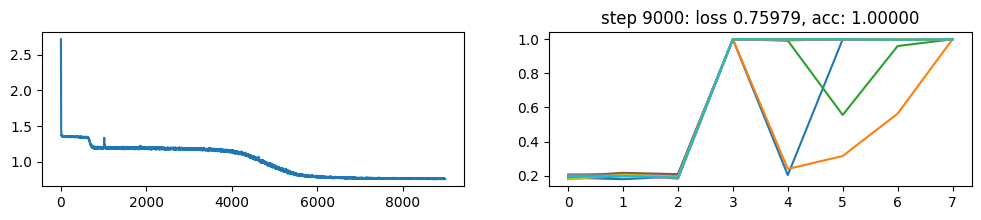

<Figure size 600x200 with 0 Axes>

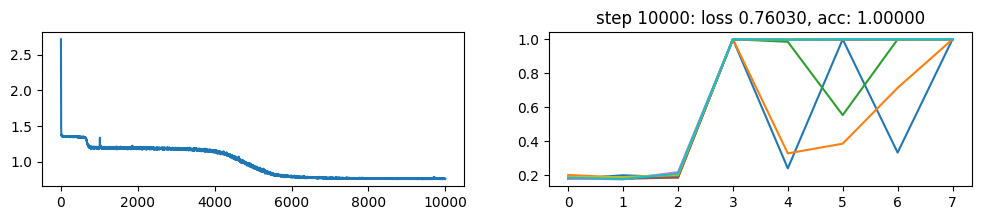

<Figure size 600x200 with 0 Axes>

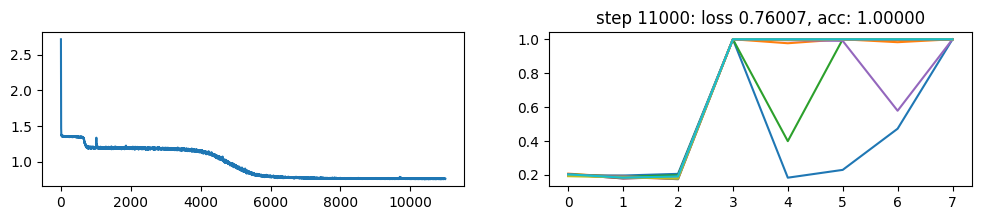

<Figure size 600x200 with 0 Axes>

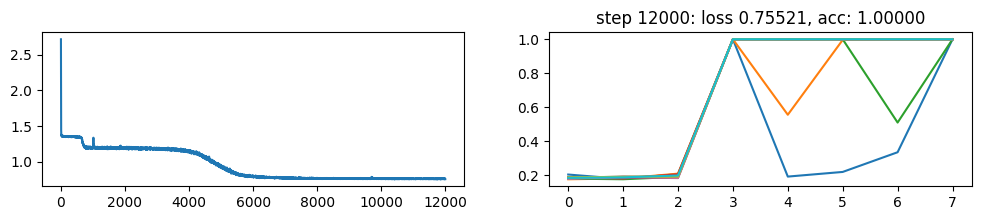

<Figure size 600x200 with 0 Axes>

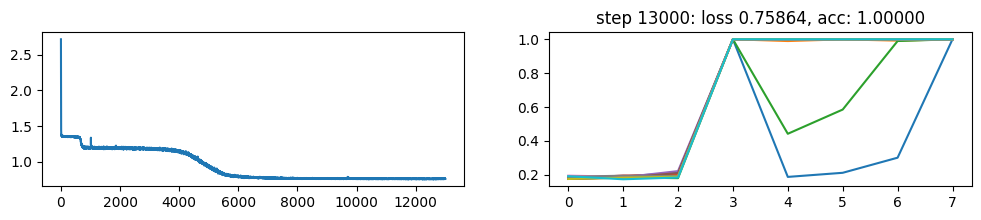

<Figure size 600x200 with 0 Axes>

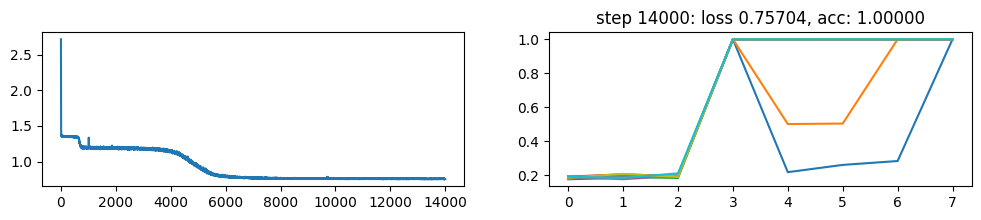

<Figure size 600x200 with 0 Axes>

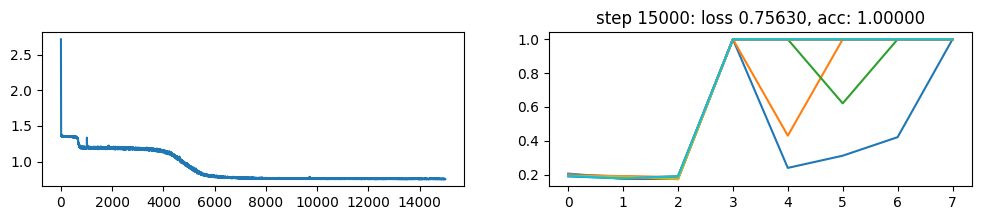

<Figure size 600x200 with 0 Axes>

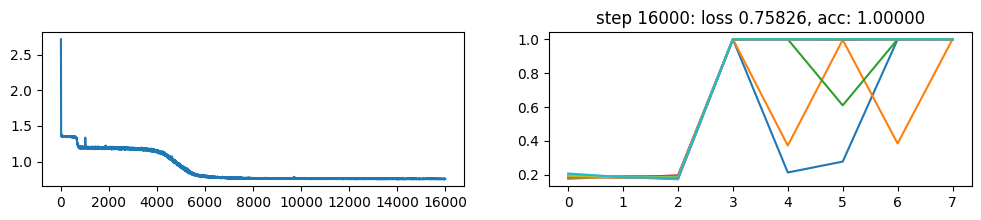

<Figure size 600x200 with 0 Axes>

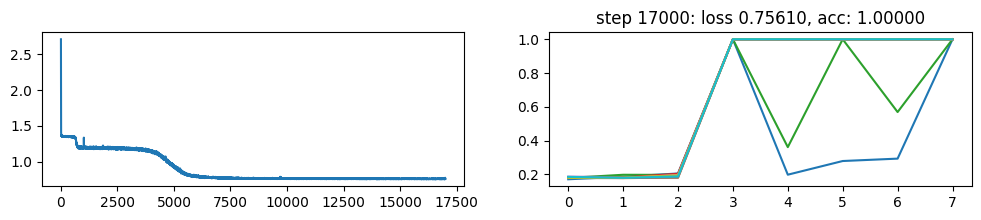

<Figure size 600x200 with 0 Axes>

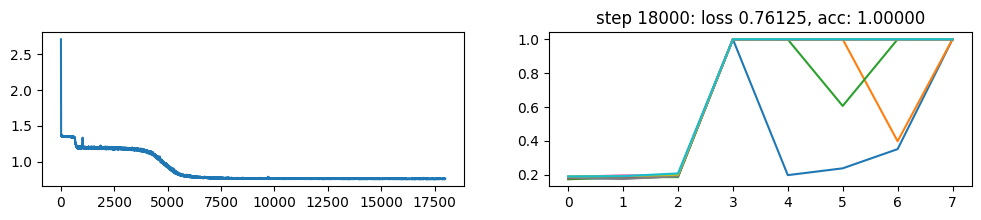

<Figure size 600x200 with 0 Axes>

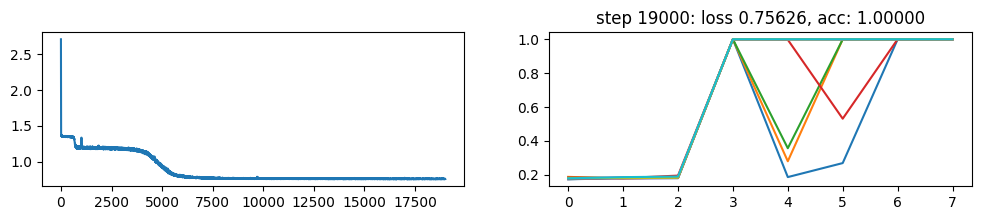

In [5]:
#| code-fold: true

def make_batch(K=10, L=6, R=6, T=3):
    pad = L+R+2

    return torch.nn.utils.rnn.pad_sequence([make_sequence(K=K, L=L, R=R, T=T) for _ in range(32)], batch_first=True, padding_value=pad)

device = 'cuda:1'
lm = LM().to(device)

optimizer = torch.optim.Adam(lm.parameters(), lr=1e-3)

Nsteps = 20000
losses = torch.zeros(Nsteps)

for step in range(Nsteps):
    batch = make_batch(10, L=L, R=R).to(device)
    inputs, targets = batch[:, :-1], batch[:, 1:]
    outputs = lm(inputs)
    
    loss = F.cross_entropy(outputs.view(-1, L+R+3), targets.reshape(-1), ignore_index=pad)    

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses[step] = loss.item()
    if step and step % 1000 == 0:
        plt.figure(figsize=(6, 2))
        fig, (axl,axr) = plt.subplots(1, 2, figsize=(12, 2))
        axl.plot(losses[:step+1].numpy())
        axr.plot(outputs[0].softmax(-1).max(-1).values.detach().cpu().view(-1,8).numpy().T, label=range(10))
        l, r = torch.where(targets[0]==stx)[0][-1].item(), torch.where(targets[0]==soh)[0][-1].item()
        acc = (outputs[0,l:r].argmax(dim=-1) == targets[0,l:r]).sum() / (r-l)
        plt.title(f'step {step}: loss {loss:.5f}, acc: {acc:.5f}')
        #plt.legend()
        plt.show()